In [84]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from matplotlib import pyplot as plt
import time
import pandas as pd

In [85]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-01-20 18:41:24--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.2’

input.txt.2         100%[===================>]   1.06M  --.-KB/s    in 0.007s  

2024-01-20 18:41:24 (158 MB/s) - ‘input.txt.2’ saved [1115394/1115394]



In [86]:
with open('input.txt', 'r', encoding='utf-8') as f:
  lines = f.read()

In [87]:
vocab = sorted(list(set(lines)))
itos = {i:ch for i, ch in enumerate(vocab)}
stoi = {ch:i for i, ch in enumerate(vocab)}

print(lines[:30])

First Citizen:
Before we proce


In [88]:
# simple tokenization by characters
def encode(s):
    return [stoi[ch] for ch in s]

def decode(l):
    return ''.join([itos[i] for i in l])

print('vocab size:', len(vocab))
decode(encode("hello"))

vocab size: 65


'hello'

In [89]:
## Creating a config object that stores some basic model params. It makes the code way more readable and removes constants and magic numbers from the code. We can keep adding to it.
MASTER_CONFIG = {
    "vocab_size": len(vocab),
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [90]:
dataset = torch.tensor(encode(lines), dtype=torch.int8)
dataset.shape

torch.Size([1115394])

In [91]:
## Generating the training data and labels for batches
def get_batches(data, split, batch_size, context_window, config=MASTER_CONFIG):
  train = data[:int(0.8 * len(data))]
  val = data[int(0.8 * len(data)) : int(0.9 * len(data))]
  test = data[int(0.9 * len(data)) : ]

  batch_data = train
  if split == 'val':
    batch_data = val
  if split == 'test':
    batch_data = test

  ## Picking random starting points
  ix = torch.randint(0, batch_data.size(0) - context_window - 1, (batch_size, ))
  x = torch.stack([batch_data[i : i+context_window] for i in ix]).long()
  y = torch.stack([batch_data[i+1 : i+context_window+1] for i in ix]).long()

  return x.to(device), y.to(device)

MASTER_CONFIG.update({
    'batch_size' : 9,
    'context_window' : 16
})

xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

[(decode(xs[i].tolist()), decode(ys[i].tolist())) for i in range(len(xs))]

[(' petitions: made', 'petitions: made\n'),
 (' Lord Hastings n', 'Lord Hastings no'),
 ("hush'd and nough", "ush'd and nought"),
 (' beseech thee, y', 'beseech thee, yo'),
 ('ch and spurs; or', 'h and spurs; or '),
 ('it.\n\nQUEEN MARGA', 't.\n\nQUEEN MARGAR'),
 (' more but abide.', 'more but abide.\n'),
 ('yet, by the fait', 'et, by the faith'),
 ('ew thy brother R', 'w thy brother Ru')]

In [92]:
## Evaluation function
@torch.no_grad()  ## we won't be computing gradients for evaluation func
def evaluate_loss(model, config=MASTER_CONFIG):
  out = {}
  model.eval()
  for split in ['train','val']:
    losses = []
    for _ in range(10):
      xb, yb = get_batches(dataset, split, config['batch_size'], config['context_window'])
      _, loss = model(xb, yb)
      losses.append(loss.item())

    out[split] = np.mean(losses)

  model.train()
  return out

In [119]:
## Train func
MASTER_CONFIG.update({
    'epochs': 5000,
    'log_interval': 10,
    'batch_size': 32,
})

def train(model, optimizer, scheduler=None, config=MASTER_CONFIG, print_logs=False):
  losses = []
  start_time = time.time()
  for epoch in range(config['epochs']):
    optimizer.zero_grad()

    xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])
    logits, loss = model(xs, targets=ys)
    loss.backward()
    optimizer.step()

    if scheduler:
      scheduler.step()

    if epoch % config['log_interval'] == 0:
      batch_time = time.time() - start_time
      x = evaluate_loss(model)
      losses += [x]
      if print_logs:
        print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config['epochs'] - epoch)/config['log_interval'] :.3f}")
      start_time = time.time()

      if scheduler:
        print("lr: ", scheduler.get_lr())

  print("validation loss: ", losses[-1]['val'])
  return pd.DataFrame(losses).plot()

In [120]:
## Generate func to generate output texts
def generate(model, config=MASTER_CONFIG, max_new_tokens=30):
  idx = torch.zeros(5,1).long().to(device)
  for _ in range(max_new_tokens):
    logits = model(idx[:, -config['context_window']: ])
    last_time_step_logits = logits[:,-1,:] ## all the batches(1), last time step, all the logits
    p = F.softmax(last_time_step_logits, dim=-1)
    idx_next = torch.multinomial(p, num_samples=1)  ## sample from the distribution to get the next token
    idx = torch.cat([idx, idx_next], dim=-1) ## Append to the sequence

  return [decode(x) for x in idx.tolist()]

Llama describes three architectural modifications to the original Transformer:
1. RMSNorm for pre-normalization
2. Rotary embeddings
3. SwiGLU activation function

In [121]:
class RMSNorm(nn.Module):
  def __init__(self, layer_shape, eps=1e-8, bias=False):
    super().__init__()
    self.register_parameter("scale", nn.Parameter(torch.ones(layer_shape)))

  def forward(self, x):
    """
    Assumes shape is (batch, seq_len, d_model)
    """
    ## frob norm is not the same as RMS. RMS = 1/sqrt(N) * frob norm
    ff_rms = torch.linalg.norm(x, dim=(1,2)) * x[0].numel() ** -.5
    raw = x / ff_rms.unsqueeze(-1).unsqueeze(-1)
    return self.scale[:x.shape[1], :].unsqueeze(0) * raw


config = {
    'batch_size': 5,
    'context_window': 11,
    'd_model': 13,
}
batch = torch.randn((config['batch_size'], config['context_window'], config['d_model']))
m = RMSNorm((config['context_window'], config['d_model']))
g = m(batch)
print(g.shape)

torch.Size([5, 11, 13])


In [122]:
def get_rotary_matrix(context_window, embedding_dim):
    R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False).to(device)
    for position in range(context_window):
        for i in range(embedding_dim//2):
            theta = 10000. ** (-2.*(i - 1) / embedding_dim)
            m_theta = position * theta
            R[position, 2*i,2*i] = np.cos(m_theta)
            R[position, 2*i,2*i+1] = - np.sin(m_theta)
            R[position, 2*i+1,2*i] = np.sin(m_theta)
            R[position, 2*i+1,2*i+1] = np.cos(m_theta)
    return R

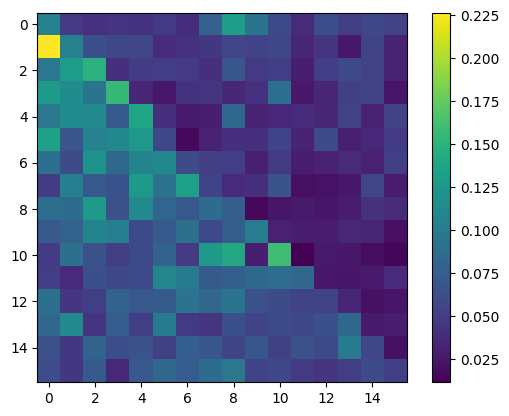

In [123]:
class RoPEMaskedAttentionHead(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config
    self.w_q = nn.Linear(config['d_model'], config['d_model'], bias=False)
    self.w_k = nn.Linear(config['d_model'], config['d_model'], bias=False)
    self.w_v = nn.Linear(config['d_model'], config['d_model'], bias=False)

    self.R = get_rotary_matrix(config['context_window'], config['d_model'])

  def get_rotary_matrix(context_window, embedding_dim):
    R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
    for position in range(context_window):
      for i in range(embedding_dim//2):
        theta = 10000. ** (-2.*(i - 1) / embedding_dim)
        m_theta = position * theta
        R[position, 2*i,2*i] = np.cos(m_theta)
        R[position, 2*i,2*i+1] = - np.sin(m_theta)
        R[position, 2*i+1,2*i] = np.sin(m_theta)
        R[position, 2*i+1,2*i+1] = np.cos(m_theta)

    return R

  def forward(self, x, return_attn_weights=False):
    b, m, d = x.shape

    q = self.w_q(x)
    k = self.w_k(x)
    v = self.w_v(x)

    q_rotated = (torch.bmm(q.transpose(0,1), self.R[:m])).transpose(0,1)
    k_rotated = (torch.bmm(k.transpose(0,1), self.R[:m])).transpose(0,1)

    activations = F.scaled_dot_product_attention(q_rotated, k_rotated, v, dropout_p = 0.1, is_causal=True)

    if return_attn_weights:
      attn_mask = torch.tril(torch.ones((m,m)), diagonal=0).to(device)
      attn_weights = torch.bmm(q_rotated, k_rotated.transpose(1,2)) / np.sqrt(d) + attn_mask
      attn_weights = F.softmax(attn_weights, dim=-1)
      return activations, attn_weights
    return activations

config = {
    'batch_size': 10,
    'd_model': 512,
    'n_heads': 8,
    'context_window': 16,
}

layer = RoPEMaskedAttentionHead(config).to(device)
batch = torch.randn((config['batch_size'], config['context_window'], config['d_model'])).to(device)
output, attn_weights = layer(batch, return_attn_weights=True)
plt.imshow(attn_weights[0].cpu().detach().numpy())
plt.colorbar()

In [124]:
class RoPEMaskedMultiheadAttention(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config
    self.heads = nn.ModuleList([RoPEMaskedAttentionHead(config) for _ in range(config['n_heads'])])
    self.linear = nn.Linear(config['n_heads'] * config['d_model'], config['d_model'])
    self.dropout = nn.Dropout(0.1)

  def forward(self, x):
    heads = [h(x) for h in self.heads]
    x = torch.cat(heads, dim=-1)
    x = self.linear(x)
    x = self.dropout(x)
    return x


MASTER_CONFIG.update({
    'n_heads': 8,
    'd_model': 128,
})
layer = RoPEMaskedMultiheadAttention(MASTER_CONFIG).to(device)
batch = torch.ones((MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model'])).to(device)
output = layer(batch)
output.shape

torch.Size([32, 16, 128])

In [125]:
class SwiGLU(nn.Module):
    """
    Swish-Gated Linear Unit
    https://arxiv.org/pdf/2002.05202v1.pdf
    """
    def __init__(self, size):
        super().__init__()
        self.config = config
        self.linear_gate = nn.Linear(size, size)
        self.linear = nn.Linear(size, size)
        self.beta = torch.randn(1, requires_grad=True)

        self.beta = nn.Parameter(torch.ones(1))
        self.register_parameter("beta", self.beta)

    def forward(self, x):
        swish_gate = self.linear_gate(x) * torch.sigmoid(self.beta * self.linear_gate(x))
        out = swish_gate * self.linear(x)
        return out

In [126]:
class LlamaBlock(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config

    self.rms = RMSNorm((config['context_window'], config['d_model']))

    self.attention = RoPEMaskedMultiheadAttention(config)
    self.feedforward = nn.Sequential(
        nn.Linear(config['d_model'], config['d_model']),
        SwiGLU(config['d_model']),
    )

  def forward(self, x):
    x = self.rms(x)
    x = x + self.attention(x)

    x = self.rms(x)
    x = x + self.feedforward(x)
    return x

In [127]:
block = LlamaBlock(MASTER_CONFIG).to(device)
block(torch.randn(MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model']).to(device)).shape

torch.Size([32, 16, 128])

model params: 2370246
validation loss:  1.5672913670539856


<Axes: >

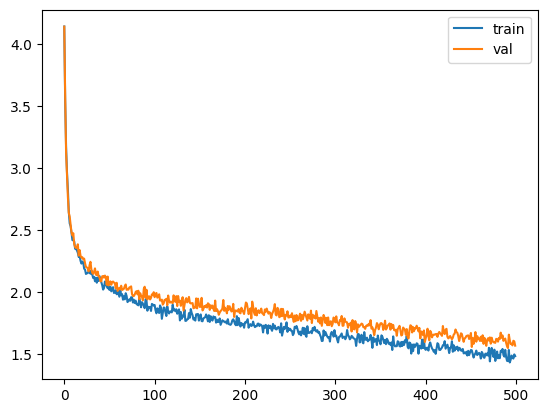

In [128]:
from collections import OrderedDict

MASTER_CONFIG.update({
    'n_layers': 4,
})

class Llama(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embeddings = nn.Embedding(config['vocab_size'], config['d_model'])
        self.llama_blocks = nn.Sequential(
            OrderedDict([(f"llama_{i}", LlamaBlock(config)) for i in range(config['n_layers'])])
        )

        self.ffn = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embeddings(idx)
        x = self.llama_blocks(x)
        logits = self.ffn(x)

        if targets is None:
            return logits

        else:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

llama = Llama(MASTER_CONFIG).to(device)
optimizer = torch.optim.Adam(llama.parameters())
train(llama, optimizer, config=MASTER_CONFIG, print_logs=False)

In [129]:
print(generate(llama, MASTER_CONFIG, 500)[0])


SOMPAT:
Am hould ha!
While tthe thy grates his has wouch knows thy chais He no his slood
Pe out ut strave!
He quity depart?

MANTICES:
I hereassin his cannot.
Despect
Second two makling dever! you proly blave not this
laid cunto us froms make with how saffer;
She never 'for was the kirgys,
As bave too slooc the come are a dumand beh of my mould him a asmend:
I have kin-we merrand my heasues of lect a ulh
Trancts that what of heok
To hold
Yis up. 
LADY IFAUENIUS:
Re:
The press you but ushdight.




## Checking for Gradient Flows
Let's inspect the gradients, we want to see how they're flowing. If there are too many gradients where the value is close to 0, that's a problem.

In [130]:
# print the percentage that are near 0
def show_grads(model, tol=1e-2):
    return sorted([(name, 100.0 * float(torch.sum(torch.abs(param) <= tol)) / float(param.nelement())) for name, param in model.named_parameters() if param.requires_grad], key=lambda t: t[1], reverse=True)

show_grads(llama)

[('llama_blocks.llama_0.attention.linear.weight', 25.68511962890625),
 ('llama_blocks.llama_3.attention.linear.weight', 25.2288818359375),
 ('llama_blocks.llama_2.attention.linear.weight', 23.094940185546875),
 ('llama_blocks.llama_1.attention.linear.weight', 21.38824462890625),
 ('llama_blocks.llama_3.attention.heads.1.w_v.weight', 17.047119140625),
 ('llama_blocks.llama_3.attention.heads.0.w_v.weight', 16.583251953125),
 ('llama_blocks.llama_3.attention.heads.4.w_v.weight', 16.015625),
 ('llama_blocks.llama_3.attention.heads.2.w_v.weight', 15.911865234375),
 ('llama_blocks.llama_3.attention.heads.3.w_v.weight', 15.7958984375),
 ('llama_blocks.llama_3.attention.heads.5.w_v.weight', 15.777587890625),
 ('llama_blocks.llama_2.attention.heads.4.w_v.weight', 15.399169921875),
 ('llama_blocks.llama_3.attention.heads.6.w_v.weight', 15.39306640625),
 ('llama_blocks.llama_2.attention.heads.3.w_v.weight', 15.386962890625),
 ('llama_blocks.llama_2.attention.heads.5.w_v.weight', 15.350341796875),